# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 10. Нейронные сети.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image`;
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 50 баллов
* Задача 2 &mdash; 40 баллов
* Задача 3 &mdash; 10 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [2]:
import numpy as np
import scipy.stats as sps
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import torch
from torch import nn

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline
print(torch.__version__)

1.11.0+cu113


Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/lecture9.pdf" target="_blank">презентацию</a> с занятия по нейронным сетям.

---
### Задача 1.

Рассмотрим двухслойную нейронную сеть, которая принимает на вход $x\in\mathbb{R}$ и возвращает $y\in\mathbb{R}$. Выход первого слоя возвращает $u \in\mathbb{R}^2$. После первого слоя используется функция активации $\sigma(x) = \frac{1}{1 + \exp(-x)}$, после второго слоя функция активации не используется (или используется тождественная). Тем самым нашу нейронную можно представить в виде

$$\widehat{y}(x) = w_{21}u_1(x) + w_{22}u_2(x) + b_2,$$

$$u_1(x) = \sigma\big(w_{11}x + b_{11}\big),$$

$$u_2(x) = \sigma\big(w_{12}x + b_{12}\big).$$



**1.** Нарисуйте схематически данную нейронную сеть. Сколько у нее обучаемых параметров?

![jupyter](./shem.jpg)

Обучаем мы веса и сдвиги, по этому обучаемых параметров здесь 7. 

**2.** Дана обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$, где $X_i \in \mathbb{R}$ и $Y_i \in \mathbb{R}$. Нейронная сеть обучается по этой выборке минимизируя MSE
$$\text{MSE} = \sum_{i=1}^n \big(Y_i - \widehat{y}(X_i)\big)^2.$$

Наша задача &mdash; выписать производные по всем параметрам сети для использования градиентного спуска. Конечно, в данном случае довольно просто выписать все производные напрямую. Мы будем выписывать их поэтапно, так вам будет проще понять общую процедуру в дальнейшем.

В силу того что иной архетектуры не предложено считаю что мы исследуем сеть из предыдущего пункта


**2.1.** Начнем с производной MSE по выходам сети
$$\frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} = 2\cdot \hat{y}(X_i) - 2\cdot Y_i $$

Теперь мы можем взять производные выходов сети по весам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial w_{21}} = u_1(X_i)$$

$$\frac{\partial \widehat{y}(X_i)}{\partial w_{22}} = u_2(X_i)$$

$$\frac{\partial \widehat{y}(X_i)}{\partial b_2} = 1$$

Наконец, выпишем производные MSE по весам последнего слоя. Для этого вспомните правило производной сложной функции из математического анализа.

$$\frac{\partial\:\text{MSE}}{\partial w_{21}} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial\:\hat{y}(X_i)} \frac{\partial \hat{y}(X_i)}{\partial w_{21}} = \sum_{j = 1} ^n(2\cdot\hat{y}(X_j) -2 Y_j)\cdot u_1(X_j) $$

$$\frac{\partial\:\text{MSE}}{\partial w_{22}} = \sum_{i=1}^n \frac{\partial \:\text{MSE}}{\partial \hat{y}(X_i)} \frac{\partial \hat{y}(X_i)}{\partial w_{22}} = \sum_{j = 1}^n(2\cdot \hat{y}(X_j) -2\cdot Y_j)\cdot u_2(X_j) $$

$$\frac{\partial\:\text{MSE}}{\partial b_2} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \hat{y}(X_i)} \frac{\partial \hat{y}(X_i)}{\partial b_2} = \sum_{j = 1}^n(2\cdot \hat{y}(X_j) -2\cdot Y_j) $$

**2.2.** Теперь будем разбираться с производным по параметрам первого слоя. Начнем с производной выхода сети по выходу певрого слоя.

$$\frac{\partial \widehat{y}(X_i)}{\partial u_1(X_i)} = w_{21}$$

$$\frac{\partial \widehat{y}(X_i)}{\partial u_2(X_i)} = w_{22}$$

Далее нам пригодится производная функции активации, запишите ее так, чтобы ответе осталась функция от $\sigma(x)$

$$\frac{\partial\:\sigma(x)}{\partial x} = \sigma(x)^2\cdot e^{-x}$$

Теперь мы можем взять производные выходов первого слоя по его параметрам

$$\frac{\partial u_1(X_i)}{\partial w_{11}} = \sigma(w_{11}\cdot X_i + b_{11})^2\cdot e^{-(w_{11}\cdot X_i + b_{11})}\cdot X_i$$

$$\frac{\partial u_1(X_i)}{\partial b_{11}} = \sigma(w_{11}\cdot X_i + b_{11})^2\cdot e^{-(w_{11}\cdot X_i + b_{11})}$$

$$\frac{\partial u_2(X_i)}{\partial w_{12}} = \sigma(w_{12}\cdot X_i + b_{12})^2\cdot e^{-(w_{12}\cdot X_i + b_{12})}\cdot X_i$$

$$\frac{\partial u_2(X_i)}{\partial b_{12}} = \sigma(w_{12}\cdot X_i + b_{12})^2\cdot e^{-(w_{12}\cdot X_i + b_{12})}$$

Наконец, выпишем производные MSE по весам первого слоя. Аналогично, запишите правило производной сложной функции и выпишите итоговый ответ.

$$\frac{\partial\:\text{MSE}}{\partial w_{11}} = \sum_{j = 1}^n((2\cdot \hat{y}({X_j}) -2\cdot Y_j)\cdot w_{21}\cdot \sigma(w_{11}\cdot X_j + b_{11})^2\cdot e^{-(w_{11}\cdot X_j + b_{11})}\cdot X_j)$$

$$\frac{\partial\:\text{MSE}}{\partial b_{11}} = \sum_{j = 1}^ n(2\cdot \hat{y}(X_j) -2\cdot Y_j)\cdot w_{21}\cdot \sigma(w_{11}\cdot X_j + b_{11})^2\cdot e^{-(w_{11}\cdot X_j + b_{11})}$$

$$\frac{\partial\:\text{MSE}}{\partial w_{12}} = \sum_{j = 1}^n(2\cdot \hat{y}(X_j) -2\cdot Y_j)\cdot w_{22} \cdot \sigma(w_{12}\cdot X_j + b_{12})^2\cdot e^{-(w_{12}\cdot X_j + b_{12})}\cdot X_j$$

$$\frac{\partial\:\text{MSE}}{\partial b_{12}} = \sum_{j = 1}^n(2\cdot \hat{y}(X_j) -2\cdot Y_j)\cdot w_{22}\cdot \sigma(w_{12}\cdot X_j + b_{12})^2\cdot e^{-(w_{12}\cdot X_j + b_{12})}$$

Вы могли заметить, мы считали производные начиная с последнего слоя и постепенно доходили до первого. Подобная процедура называется *методом обратного распространения ошибки* (backpropagation), ее преимуществом является эффективное вычисление градиентов.

**3.** Выпишите формулу градиентного спуска по одному из параметров.
Раз сказали по одному выберем самый простой $b_2$

$\hat{b_2|}_{t+1} = \hat{b_2|}_t - \eta \cdot \sum_{j = 1}^n(2\cdot \hat{y}(X_j) -2\cdot Y_j)$

Пусть обучающая выборка очень большая. Что нужно делать в таком случае? Запишите, как нужно поменять правило обновления параметров.

$\hat{b_2|}_{t+1} = \hat{b_2|}_t - \eta \cdot n \cdot (2\cdot \hat{y}(X_1) -2\cdot Y_1) $

---
### Задача 2.

Реализуйте класс нейронной сети из задачи 1 в стиле scikit-learn, например, см. шаблон класса задачи 4 из <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/task6.html#Задача-4." target="_blank">задания 6</a>. Предусмотрите возможность обучения по случайным батчам. При реализации можно использовать только библиотеку `numpy`.

In [12]:
class MyNeyronet:
    def __init__(self, lambd=0.1, count_of_step=100, batch_size = 100):
        self.batch_size = batch_size
        self.lambd = lambd
        self.count_of_step = count_of_step
        # order of param w11 w12 b11 b12 w21 w22 b2
        np.random.seed(37372114)
        self.theta = np.random.rand(7, 1)
        #self.theta = np.zeros((7, 1))
    def sigma(self, X):
        return 1/(1 + 2.7**(X + 1))
    @property
    def w11(self):
        return float(self.theta[0])
    
    @property
    def w12(self):
        return float(self.theta[1])
    
    @property
    def b11(self):
        return float(self.theta[2])

    @property
    def b12(self):
        return float(self.theta[3])
    
    @property
    def w21(self):
        return float(self.theta[4])
    
    @property
    def w22(self):
        return float(self.theta[5])
    
    @property
    def b2(self):
        return float(self.theta[6])
    
    def u1(self, X):
        return self.sigma(self.w11 * X + self.b11)
    
    def u2(self, X):
        return self.sigma(self.w12 * X + self.b12)
    
    def predict(self, X):
        return self.sigma(X * self.w11 + self.b11) * self.w21 + self.sigma(X * self.w12 + self.b12) * self.w22 + self.b2
    
    def make_step(self, X, Y):
        Y_hat = self.predict(X)
        helper0 = 2 * (Y_hat - Y)
        Db2 = helper0.sum()
        u2 = self.sigma(self.w12 * X + self.b12)
        u1 = self.sigma(self.w11 * X + self.b11)
        Dw21 = (helper0 * u1).sum()
        Dw22 = (helper0 * u2).sum()
        helper1 = u1 * u1 * self.w21 * 2.7**(-self.w11 * X - self.b11)
        helper2 = u2 * u2 * self.w22 * 2.7**(-self.w12 * X - self.b12)
        Dw11 = (X * helper1 * helper0).sum()
        Db11 = (helper1 * helper0).sum()
        Dw12 = (X * helper2 * helper0).sum()
        Db12 = (helper1 * helper0).sum()        
        D = np.array([[Dw11], [Dw12], [Db11], [Db12], [Dw21], [Dw22], [Db2]])
        self.theta = self.theta - self.lambd * D
        
    def fit(self, X, Y):
        for i in range(self.count_of_step):
            indexe = np.random.randint(low=0, high=X.shape[0], size=(self.batch_size, 1))
            self.make_step(np.array([X[i] for i in indexe]), np.array([Y[i] for i in indexe]))

Сгенерируем данные. Возьмите какую-либо нелинейную функцию $y(x)$.

In [13]:
sample_size = int(10000)
np.random.seed(seed=781641781)
X = sps.norm.rvs(size=(sample_size, 1))
y = X * X
assert y.shape == (sample_size, 1)

Обучите нейронную сеть на этих данных, а также простую линейную регрессию.

Обучим нашу сеть

In [14]:
neyro_net = MyNeyronet(lambd=0.00001, count_of_step = 1000)
neyro_net.fit(X, y)
ans = neyro_net.predict(X)
model = LinearRegression()
model.fit(X, y)
ans_lin = model.predict(X)

Нарисуем получуенные данные

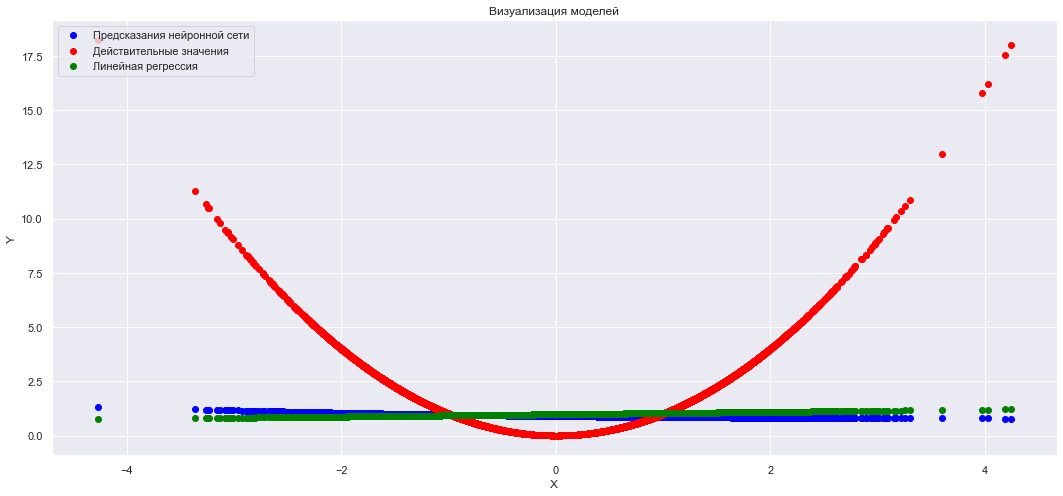

In [15]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(X, ans, color="blue", label="Предсказания нейронной сети")
ax.scatter(X, y, color="red", label="Действительные значения")
ax.scatter(X, ans_lin, color="green", label="Линейная регрессия")
ax.set_title('Визуализация моделей')
ax.legend(loc="upper left")
ax.set_xlabel('X')
ax.set_ylabel("Y")
plt.show()

Сгенерируем тестовые данные и посчитаем на них MSE

In [300]:
np.random.seed(seed=384596)
test = sps.norm.rvs(size=(sample_size, 1))
print("Для линейной регрессии", metrics.mean_squared_error(test * test, model.predict(test)) ** 0.5)
print("Для \"Искуственного интелекта\"", metrics.mean_squared_error(test * test, neyro_net.predict(test)) ** 0.5)

Для линейной регрессии 1.4123677390929075
Для "Искуственного интелекта" 1.4097713892163724


Вполне очевидно,  что наша нейронная сеть это просто МНК. MSE такой маленький так как большинство точек в окрестности нуля, а ноль мы не плохо приближаем.

В качестве второй функции выберем например $e^x$

Повторите вычисления для другой нелинейной функции $y(x)$.

In [308]:
sample_size = int(10000)
np.random.seed(seed=781641781)
X = sps.norm.rvs(size=(sample_size, 1))
y = 2.7 ** X
assert y.shape == (sample_size, 1)

Обучим модели

In [338]:
neyro_net = MyNeyronet(lambd=0.00001, count_of_step = 100)
neyro_net.fit(X, y)
ans = neyro_net.predict(X)
model = LinearRegression()
model.fit(X, y)
ans_lin = model.predict(X)

Построим графики

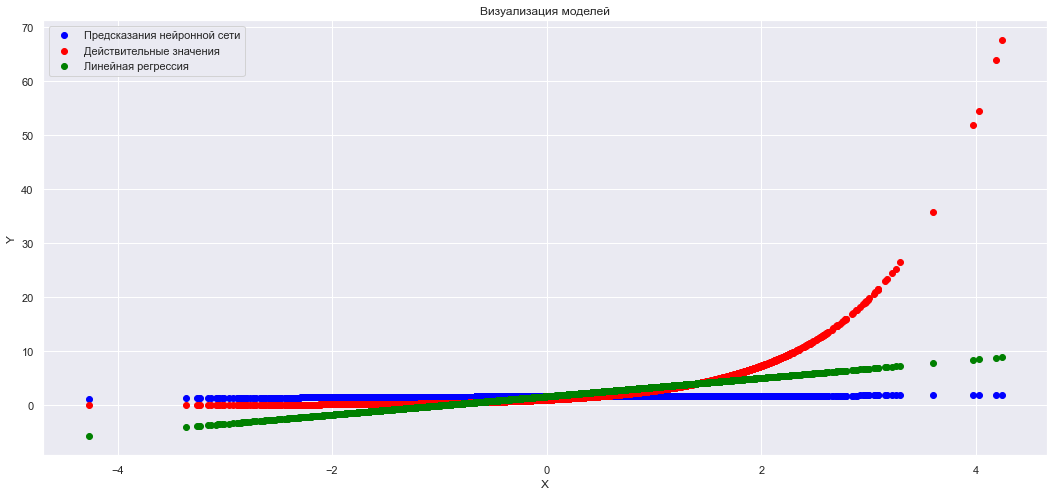

In [339]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(X, ans, color="blue", label="Предсказания нейронной сети")
ax.scatter(X, y, color="red", label="Действительные значения")
ax.scatter(X, ans_lin, color="green", label="Линейная регрессия")
ax.set_title('Визуализация моделей')
ax.legend(loc="upper left")
ax.set_xlabel('X')
ax.set_ylabel("Y")
plt.show()

Посчитаем MSE

In [340]:
np.random.seed(seed=384596)
test = sps.norm.rvs(size=(sample_size, 1))
print("Для линейной регрессии", metrics.mean_squared_error(2.7 ** test, model.predict(test)) ** 0.5)
print("Для \"Искуственного интелекта\"", metrics.mean_squared_error(2.7 ** test, neyro_net.predict(test)) ** 0.5)

Для линейной регрессии 1.2473123982055059
Для "Искуственного интелекта" 1.9615614173460143


**Вывод:**
Наша нейронная сеть из - за того что в ней мало слоев - просто линейная регрессия. Увы, я ждал большего

---
### Задача 3.

Теперь напишите рассмотренную ранее нейронную сеть с помощью библиотеки `pytorch`, используя Sequential-стиль. Перед выполнением задачи рекомендуется посмотреть <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/nn_simple_examples.html#3.-Готовые-модули-из-PyTorch" target="_blank">ноутбук</a> с занятия. Функция активации реализована как `torch.nn.Sigmoid`.

*Внимание.* Для выполнения задачи потребуется установить библиотеку `pytorch`. Альтернативный вариант &mdash; выполнение в <a href="https://colab.research.google.com" target="_blank">Google Colab</a>. Учитывайте, что при длительном бездействии Colab может сам завершить работу ядра.

Запишем MSE и функцию активации

In [351]:
def optim_func(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)
def act_func(x):
    return 1/(1 + 2.7**(x + 1))

Переведем данные в торч и заполним коэффициенты 0

In [359]:
X_t = torch.Tensor(X)
y_t = torch.Tensor(y)
w11 = torch.zeros(1, requires_grad=True)
b11 = torch.zeros(1, requires_grad=True)
w12 = torch.zeros(1, requires_grad=True)
b12 = torch.zeros(1, requires_grad=True)
w21 = torch.zeros(1, requires_grad=True)
b2 = torch.zeros(1, requires_grad=True)
w22 = torch.zeros(1, requires_grad=True)
# Количество итераций
num_iter = 10000

# Скорость обучения для параметров
lr_w = 0.01
lr_b = 0.05

Непосредственно процесс обучения

In [360]:
for i in range(num_iter):
    # Forward pass: предсказание модели
    y_pred =  act_func(X_t * w11 + b11) * w21 + act_func(X_t * w12 + b12) * w22 + b2

    # Подсчет оптимизируемой функции (MSE)
    loss = optim_func(y_pred, y_t)

    # Bakcward pass: подсчет градиентов
    loss.backward()

    # Оптимизация: обновление параметров

    w11.data -= lr_w * w11.grad.data
    b11.data -= lr_b * b11.grad.data
    w12.data -= lr_w * w12.grad.data
    b12.data -= lr_b * b12.grad.data
    w21.data -= lr_w * w21.grad.data
    b2.data -= lr_b * b2.grad.data
    w22.data -= lr_w * w22.grad.data
    
    w11.grad.zero_()
    b11.grad.zero_()
    w12.grad.zero_()
    b12.grad.zero_()
    w21.grad.zero_()
    b2.grad.zero_()
    w22.grad.zero_()


Визуализируем ответ модели

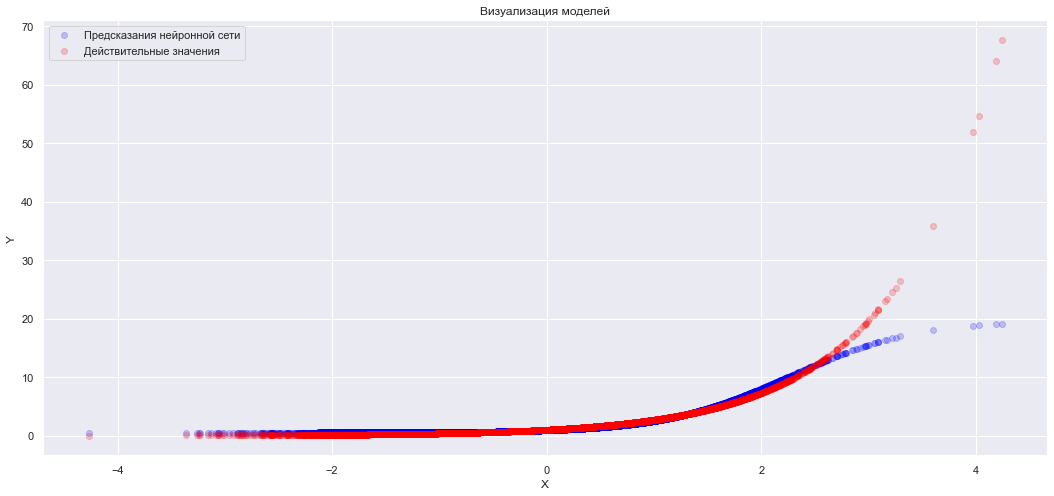

In [361]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(X_t.detach().numpy() , y_pred.detach().numpy() , color="blue", label="Предсказания нейронной сети", alpha = 0.2)
ax.scatter(X, y, color="red", label="Действительные значения", alpha = 0.2)
ax.set_title('Визуализация моделей')
ax.legend(loc="upper left")
ax.set_xlabel('X')
ax.set_ylabel("Y")
plt.show()

Обучите нейросеть на рассмотренных ранее данных. Используйте код с занятия.

Посчитаем MSE для тестовой выборки

In [363]:
test_t = torch.Tensor(test)
ytest_t = torch.Tensor(2.7 ** test)
print(float(optim_func(act_func(test_t * w11 + b11) * w21 + act_func(test_t * w12 + b12) * w22 + b2, ytest_t)))

0.14387357234954834


Не плохо, совсем не плохо.

Вывод : 1) Торч работает намного быстрее 2) Или в первом пункте у меня ошибка или в торче градиент как - то хитро считаеться , но в sclear стиле скорость обучения на одних и тех же данных приходилось ставить намного ниже чтобы небыло расхождения.